In [265]:
import scipy
import scipy.sparse
import cPickle
import logging
import implicit
reload(implicit)
import implicit.approximate_als
reload(implicit.approximate_als)
import implicit.bpr
reload(implicit.bpr)
import sklearn
import numpy as np
import itertools
import random
import pandas as pd
import time
import lightfm
import lightfm.evaluation
from lightfm import LightFM
import tqdm
import seaborn as sns
%matplotlib inline
import util as C
reload(C)
import functools
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [266]:
logging.basicConfig(level = logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [267]:
channel_helper = C.get_channel_helper()
user_helper = C.get_user_helper()

In [268]:
channel_helper.load_index_data()
channel_helper.load_meta_data()

In [269]:
channel_cid2idx, channel_idx2cid = channel_helper.channel_cid2idx, channel_helper.channel_idx2cid
channel_data, channel_pid_data = channel_helper.channel_data, channel_helper.channel_pid_data

In [270]:
%%time
train_mat_csr = C.load_mat(C.TRAIN_USER_ITEM_MAT_PATH)
test_mat_csr = C.load_mat(C.TEST_USER_ITEM_MAT_PATH)
train_mat = train_mat_csr.tocoo()
test_mat = test_mat_csr.tocoo()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.4 ms


In [271]:
train_mat_csr.shape, test_mat_csr.shape

((200000, 137344), (200000, 137344))

In [314]:
%%time
# train_mat2 = implicit.nearest_neighbours.bm25_weight(train_mat, K1=2.0, B=0.8)
# train_mat2 = implicit.nearest_neighbours.tfidf_weight(train_mat)
train_mat2 = train_mat.copy()
# train_mat2 = implicit.nearest_neighbours.bm25_weight(train_mat, K1 = 100, B = 0.8) #default 
train_mat_csr2 = train_mat2.tocsr()

CPU times: user 392 ms, sys: 0 ns, total: 392 ms
Wall time: 388 ms


In [273]:
train_mat_csr.nnz, train_mat_csr2.nnz, test_mat_csr.nnz

(1327635, 1327635, 200862)

In [274]:
train_users_idx = np.arange(train_mat.shape[0])
test_users_idx = np.array(list(set(test_mat.row)))
test_users_idx.sort()

In [275]:
np.random.seed(42)
n_users = 2000
np.random.shuffle(test_users_idx)
test_user_ids = test_users_idx[:n_users]
np.random.shuffle(train_users_idx)
train_user_ids = train_users_idx[:n_users]

In [276]:
lfm_item_ids = np.arange(train_mat.shape[1])

In [277]:
test_meta_df = pd.read_csv(C.TEST_USER_ITEM_META_PATH, index_col=0)

In [278]:
test_meta_df.head(3)

,origin_idx,cn,lang,br,subs
119737,2102869,cu,en,huawei,6
72272,2026103,at,fr,samsung,6
158154,1385691,us,en,samsung,6


In [279]:
test_meta_df.shape

(50000, 5)

# Evaluation

In [280]:
def compute_pred(model, user_id, N = 10, test = False, recalculate_user=False):
    if model.__module__.startswith('implicit'):
        if test:
            pred = model.recommend(user_id, user_items = train_mat_csr2, N = N)
            return pred
        else:
            user = model._user_factor(user_id, user_items = train_mat_csr2, 
                                      recalculate_user = recalculate_user)
            scores = model.item_factors.dot(user)
    else:
        scores = model.predict(user_ids = user_id, item_ids = lfm_item_ids, num_threads = 8)
    scores = -scores
    pred_idxs = np.argpartition(scores, N)[:N]
    pred = [(x, -scores[x]) for x in pred_idxs]
    pred.sort(key = lambda x: -x[1])
    return pred

    
def eval_user_recomm(model, user_id, N = 10, verbose = True, test = True):
    if test:
        truth_idxs = test_mat_csr[user_id].indices
    else:   
        truth_idxs = train_mat_csr[user_id].indices
    base_idxs = train_mat_csr2[user_id].indices
    pred = compute_pred(model, user_id, N = N, test = test)
    pred_idxs = [x[0] for x in pred]
    intersect = len(set(pred_idxs) & set(truth_idxs))
    a = intersect
    b = len(pred_idxs)
    c = len(truth_idxs)
    assert(b == N)
    
    if verbose:
        print('base ...')
        base_pids = [channel_idx2cid[x] for x in base_idxs]
        for pid in base_pids:
            print('- {} {}'.format(pid, channel_pid_data[pid]['title']))

        print('pred ...')
        pred_pids = [channel_idx2cid[x] for x in pred_idxs]
        for idx, pid in enumerate(pred_pids):
            print('- {} {} {} {}'.format(pid, channel_pid_data[pid]['title'], pred_idxs[idx], pred[idx][1]))

        print('truth ...')
        true_pids = [channel_idx2cid[x] for x in truth_idxs]
        for pid in true_pids:
            print('- {} {}'.format(pid, channel_pid_data[pid]['title']))
    return a, b, c

def eval_all_users(model, user_ids, N = 10, test = True):
    A, B, C = 0, 0, 0
    for user_id in user_ids:
        a, b, c = eval_user_recomm(model, user_id, N = N, verbose = False, test = test)
        A += a
        B += b 
        C += c
    # precision, recall
    return round(A * 1.0 / B, 4), round(A * 1.0 / C, 4)

def item_recomm(model, cid, N=20,  verbose = True):
    idx = channel_cid2idx[cid]
    if model.__module__.startswith('implicit'):
        related = model.similar_items(idx, N=N)
        res = []
        for rid, score in related:
            pid= channel_idx2cid[rid]
            title = channel_pid_data[pid]['title']
            res.append((pid, title, score))
            
    else: # lightfm model.
        item_embeddings = model.item_embeddings
        scores = item_embeddings.dot(item_embeddings[idx])
        norm_scores = -scores / np.linalg.norm(item_embeddings, axis = -1)
        scores_idx = norm_scores.argpartition(N)
        scores_idx = scores_idx[:N]
        scores_idx_value = list(zip(scores_idx, [norm_scores[x] for x in scores_idx]))
        scores_idx_value = sorted(scores_idx_value, key = lambda x: x[1])
        res = []
        for idx, value in scores_idx_value:
            pid= channel_idx2cid[idx]
            title = channel_pid_data[pid]['title']
            res.append((pid, title, value))

    if verbose:
        for pid, title, score in res:
            print('pid={}, title={}, score={:.2f}'.format(pid, title, score))
    return res

In [300]:
class History:
    def __init__(self, model, test_user_ids, train_user_ids):
        self.model = model
        self.test_user_ids = test_user_ids
        self.train_user_ids = train_user_ids
        self.test_scores = []
        self.train_scores = []
        self.epoch_number = 0

    def add_test_score(self, score):
        self.test_scores.append(score)
        
    def add_train_score(self, score):
        self.train_scores.append(score)
    
    def eval_test_users(self):
        return eval_all_users(model = self.model,user_ids = self.test_user_ids, test = True)

    def eval_train_users(self):
        return eval_all_users(model = self.model,user_ids = self.train_user_ids, test = False)
        
def fit_callback(hist, iterations, elapsed, interval = 1):
    if iterations % interval != 0: return
    start = time.time()
    test_score = hist.eval_test_users()
    hist.add_test_score(test_score)
    train_score = hist.eval_train_users()
    hist.add_train_score(train_score)
    end = time.time()
    print('iteration #{}, elapsed = ({:.2f}, {:.2f}), train_score = {}, test_score = {}'.
          format(iterations, elapsed, end - start, train_score, test_score))


In [282]:
def plot_precision_history(history):
    plt.plot([x[0] for x in history.train_scores])
    plt.plot([x[0] for x in history.test_scores])
    plt.xlabel('# of iteratios')
    plt.ylabel('p@k')
    plt.legend(['train', 'test'])

def plot_recall_history(history):
    plt.plot([x[1] for x in history.train_scores])
    plt.plot([x[1] for x in history.test_scores])
    plt.xlabel('# of iteratios')
    plt.ylabel('r@k')
    plt.legend(['train', 'test'])

# Train ALS Model

这个模型综合效果不错, user, item recomm都还行

即便是数据量缩减不少，item recomm也还不错

In [95]:
np.random.seed(42)
als_model = implicit.als.AlternatingLeastSquares(
    factors= 100, 
    regularization = 0.01,
    iterations = 10)
    #calculate_training_loss = True)
als_history = History(als_model, test_user_ids, train_user_ids)
als_model.fit_callback = functools.partial(fit_callback, als_history)

In [142]:
np.mean(train_mat_csr2.data)

6.4929743399990345

In [96]:
%%time
als_model.fit(train_mat_csr2.T)

DEBUG:implicit:Converting input to CSR format
DEBUG:implicit:Converted input to CSR in 0.058s
DEBUG:implicit:Calculated transpose in 0.055s
DEBUG:implicit:initialize factors in 0.650916814804
DEBUG:implicit:finished iteration 0 in 4.779s


iteration #0, elapsed = (4.78, 16.61), train_score = (0.2374, 0.3787), test_score = (0.0291, 0.0728)


DEBUG:implicit:finished iteration 1 in 4.585s


iteration #1, elapsed = (4.59, 17.14), train_score = (0.3188, 0.5085), test_score = (0.0699, 0.1749)


DEBUG:implicit:finished iteration 2 in 4.519s


iteration #2, elapsed = (4.52, 16.74), train_score = (0.3211, 0.5123), test_score = (0.0865, 0.2163)


DEBUG:implicit:finished iteration 3 in 4.448s


iteration #3, elapsed = (4.45, 16.15), train_score = (0.3181, 0.5075), test_score = (0.0886, 0.2216)


DEBUG:implicit:finished iteration 4 in 4.387s


iteration #4, elapsed = (4.39, 17.42), train_score = (0.3151, 0.5027), test_score = (0.0895, 0.2237)


DEBUG:implicit:finished iteration 5 in 4.709s


iteration #5, elapsed = (4.71, 16.38), train_score = (0.3126, 0.4986), test_score = (0.0897, 0.2243)


DEBUG:implicit:finished iteration 6 in 4.623s


iteration #6, elapsed = (4.62, 16.83), train_score = (0.3107, 0.4956), test_score = (0.0898, 0.2246)


DEBUG:implicit:finished iteration 7 in 4.620s


iteration #7, elapsed = (4.62, 16.65), train_score = (0.3089, 0.4927), test_score = (0.0902, 0.2256)


DEBUG:implicit:finished iteration 8 in 5.011s


iteration #8, elapsed = (5.01, 16.54), train_score = (0.3075, 0.4904), test_score = (0.0902, 0.2256)


DEBUG:implicit:finished iteration 9 in 4.686s


iteration #9, elapsed = (4.69, 16.75), train_score = (0.3066, 0.4891), test_score = (0.0901, 0.2253)
CPU times: user 23min 25s, sys: 32min 12s, total: 55min 38s
Wall time: 3min 34s


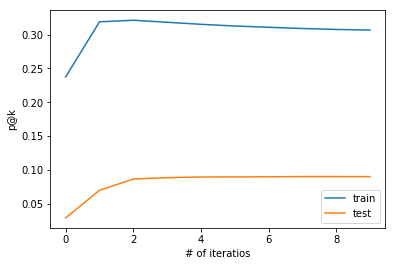

In [97]:
plot_precision_history(als_history)

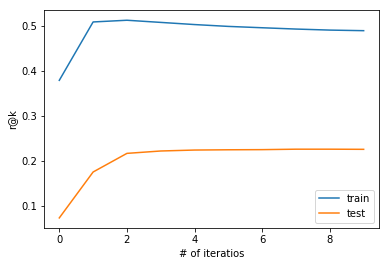

In [98]:
plot_recall_history(als_history)

# ALS Validation

In [100]:
lang = 'de'
users_idx = test_meta_df[test_meta_df['lang'] == lang].index
user_id = users_idx[np.random.randint(0, len(users_idx) - 1)]
eval_user_recomm(als_model, user_id)

base ...
- 574393 6 Minute English
- 493867 Klatsch & Tratsch – Niemand muss ein Promi sein
- 1138693 Besser als Sex
pred ...
- 574385 The English We Speak 26236 0.40444111824
- 222520 Happy, holy & confident. Dein Podcast fürs Herz und den Verstand 121141 0.258255898952
- 574409 6 Minute Grammar 115801 0.246490076184
- 979035 Eine Stunde History  - Deutschlandfunk Nova 107801 0.244291856885
- 574415 6 Minute Vocabulary 26353 0.242610350251
- 342339 Lage der Nation - der Politik-Podcast aus Berlin 50830 0.214995414019
- 1284210 Erfolgreich mit praktischer Psychologie - Wirtschaftspsychologie 127448 0.210041701794
- 1105809 Woher weißt Du das? 51307 0.202497288585
- 33259 Einschlafen Podcast 22850 0.200601622462
- 1114825 Beste Freundinnen 80829 0.196726992726
truth ...
- 2164 All Ears English Podcast | Real English Vocabulary | Conversation | American Culture
- 31184 Effizienter Lernen - Arbeiten - Leben | Thomas Mangold | Der Podcast zum effizienten und maßgeschneidertem Selbst-Manage

(1, 10, 4)

In [106]:
ref_pids = [486852, 1241617, 285553, 1215926]
_= item_recomm(als_model, 486852, N = 50)

pid=486852, title=Deep Learning: Zero to One, score=1.00
pid=1107580, title=Amazon Web Services: AWS re:Invent 2017 Breakout Sessions | Containers, score=0.96
pid=485455, title=This Week in Machine Learning & AI, score=0.95
pid=442472, title=Introduction to Python, score=0.95
pid=480423, title=IBM Analytics Insights Podcasts, score=0.95
pid=2348, title=Learning Machines 101, score=0.95
pid=402010, title=This Week in Machine Learning & Artificial Intelligence (AI) Podcast, score=0.95
pid=538016, title=Machine Learning – Software Engineering Daily, score=0.95
pid=650841, title=Machine Learning Guide, score=0.95
pid=26120, title=Linear Digressions, score=0.95
pid=1253615, title=Business Innovators (Video), score=0.95
pid=33099, title=Distributed Podcast, score=0.95
pid=321762, title=Crypto-Gram Security Podcast, score=0.95
pid=21809, title=VMware - A Connected Social Media Showcase, score=0.95
pid=650739, title=Talking Machines, score=0.95
pid=89540, title=15 Minute Pools Podcast / Improv

# Train BPR Model

这个模型训练user推荐太差

而且当数据量少的时候，item推荐效果也不行

In [112]:
np.random.seed(42)
bpr_model = implicit.bpr.BayesianPersonalizedRanking(
    factors= 100, 
    regularization = 0.01,
    iterations = 30)
    #calculate_training_loss = True)

In [114]:
%%time
bpr_model.fit(train_mat_csr2.T)
# bpr_history.eval_test_users()

DEBUG:implicit:Converting input to COO format
DEBUG:implicit:Converted input to COO in 0.013s
DEBUG:implicit:fit epoch 0 in 0.124s (87.18% ranked correctly)
DEBUG:implicit:fit epoch 1 in 0.121s (87.84% ranked correctly)
DEBUG:implicit:fit epoch 2 in 0.121s (88.42% ranked correctly)
DEBUG:implicit:fit epoch 3 in 0.122s (89.01% ranked correctly)
DEBUG:implicit:fit epoch 4 in 0.125s (89.54% ranked correctly)
DEBUG:implicit:fit epoch 5 in 0.121s (90.03% ranked correctly)
DEBUG:implicit:fit epoch 6 in 0.154s (90.49% ranked correctly)
DEBUG:implicit:fit epoch 7 in 0.140s (90.88% ranked correctly)
DEBUG:implicit:fit epoch 8 in 0.159s (91.30% ranked correctly)
DEBUG:implicit:fit epoch 9 in 0.142s (91.68% ranked correctly)
DEBUG:implicit:fit epoch 10 in 0.138s (92.02% ranked correctly)
DEBUG:implicit:fit epoch 11 in 0.136s (92.35% ranked correctly)
DEBUG:implicit:fit epoch 12 in 0.138s (92.67% ranked correctly)
DEBUG:implicit:fit epoch 13 in 0.136s (92.95% ranked correctly)
DEBUG:implicit:fit e

CPU times: user 59.8 s, sys: 16 ms, total: 59.9 s
Wall time: 4.39 s


In [115]:
%%time
eval_all_users(bpr_model, test_user_ids)

CPU times: user 55.8 s, sys: 1min 18s, total: 2min 13s
Wall time: 8.49 s


(0.0, 0.0)

In [116]:
ref_pids = [486852, 1241617, 285553, 1215926]
_= item_recomm(bpr_model, 486852)

pid=486852, title=Deep Learning: Zero to One, score=1.00
pid=427132, title=Slow Boat Sailing Podcast, score=0.80
pid=87361, title=C'est pas du vent, score=0.80
pid=375087, title=The Vegan Alliance, score=0.80
pid=46119, title=Mormon Expression, score=0.80
pid=1079517, title=The Instagram Stories, score=0.80
pid=103725, title=Brian Lehrer's Podcast About "Parks and Recreation", score=0.79
pid=403173, title=Allo La Planète, score=0.79
pid=597321, title=Bruce R McConkie General Conference, score=0.79
pid=271544, title=The Fifth Estate, score=0.79
pid=575624, title=Only Artists, score=0.79
pid=456658, title=Área de Transferência, score=0.79
pid=24706, title=The Download Youth Ministry Show (Video), score=0.79
pid=82086, title=Sleep Music for Relaxation and Sound Sleeping! (aac), score=0.79
pid=1096936, title=In Depth, Out Loud, score=0.79
pid=1215292, title=Sex Talk Podcast, score=0.78
pid=279561, title=Strength and Performance Podcast: Weekly In-Depth Interviews With Leading Strength and 

# Train LightFM Model

user, item recomm效果也都还行，在小规模数据下面也可以work

In [315]:
lfm_model = C.MyLightFM(no_components=100, learning_rate=0.02, random_state = 42, loss = 'warp')                        
lfm_history = History(lfm_model, test_user_ids[:200], train_user_ids[:200])
lfm_model.fit_callback = functools.partial(fit_callback, lfm_history, interval = 10)

In [321]:
%%time
lfm_model.fit_partial(train_mat2, epochs = 100, num_threads = 8, sample_weight=train_mat2)

iteration #100, elapsed = (1.23, 4.55), train_score = (0.177, 0.2746), test_score = (0.0895, 0.2229)
Epoch 100 in 1.23s
Epoch 101 in 1.22s
Epoch 102 in 1.22s
Epoch 103 in 1.22s
Epoch 104 in 1.23s
Epoch 105 in 1.23s
Epoch 106 in 1.22s
Epoch 107 in 1.22s
Epoch 108 in 1.23s
Epoch 109 in 1.22s
iteration #110, elapsed = (1.22, 4.48), train_score = (0.1805, 0.2801), test_score = (0.092, 0.2291)
Epoch 110 in 1.22s
Epoch 111 in 1.23s
Epoch 112 in 1.23s
Epoch 113 in 1.23s
Epoch 114 in 1.23s
Epoch 115 in 1.23s
Epoch 116 in 1.25s
Epoch 117 in 1.23s
Epoch 118 in 1.24s
Epoch 119 in 1.23s
iteration #120, elapsed = (1.23, 4.49), train_score = (0.182, 0.2824), test_score = (0.0925, 0.2304)
Epoch 120 in 1.23s
Epoch 121 in 1.22s
Epoch 122 in 1.22s
Epoch 123 in 1.21s
Epoch 124 in 1.21s
Epoch 125 in 1.21s
Epoch 126 in 1.21s
Epoch 127 in 1.21s
Epoch 128 in 1.21s
Epoch 129 in 1.24s
iteration #130, elapsed = (1.21, 4.49), train_score = (0.1865, 0.2894), test_score = (0.0915, 0.2279)
Epoch 130 in 1.21s
Epoch 

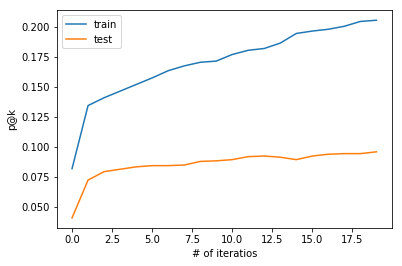

In [322]:
plot_precision_history(lfm_history)

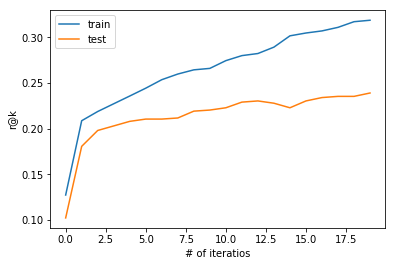

In [323]:
plot_recall_history(lfm_history)

In [324]:
%%time
eval_all_users(lfm_model, test_user_ids, N = 10)

CPU times: user 2min 31s, sys: 444 ms, total: 2min 32s
Wall time: 22.9 s


(0.0882, 0.2206)

# LFM rank mechanism

In [124]:
%%time
_ranks = lfm_model.predict_rank(test_mat_csr, train_mat_csr2, num_threads=8)

CPU times: user 37min 1s, sys: 1.15 s, total: 37min 3s
Wall time: 4min 48s


In [125]:
ranks = _ranks.copy()

In [126]:
user_id = test_users_idx[0]

In [127]:
test_mat_csr[user_id], train_mat_csr2[user_id], _ranks[user_id].indices, _ranks[user_id].data

(<1x137344 sparse matrix of type '<type 'numpy.float32'>'
 	with 4 stored elements in Compressed Sparse Row format>,
 <1x137344 sparse matrix of type '<type 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 array([ 11671,  84784, 115708, 124604], dtype=int32),
 array([  12.,   18.,   25.,  466.], dtype=float32))

In [128]:
def lfm_precision(k):
    ranks = _ranks.copy()
    test_interactions = test_mat_csr
    ranks.data = np.less(ranks.data, k, ranks.data)
    precision = np.squeeze(np.array(ranks.sum(axis=1))) / k
    precision = precision[test_interactions.getnnz(axis=1) > 0]
    print('precision at {}: mean = {}'.format(k, np.mean(precision)))

def lfm_recall(k):
    ranks = _ranks.copy()
    test_interactions = test_mat_csr
    ranks.data = np.less(ranks.data, k, ranks.data)
    retrieved = np.squeeze(test_interactions.getnnz(axis=1))
    hit = np.squeeze(np.array(ranks.sum(axis=1)))
    hit = hit[test_interactions.getnnz(axis=1) > 0]
    retrieved = retrieved[test_interactions.getnnz(axis=1) > 0]
    recall = hit / retrieved
    print('recall at {}: mean = {}'.format(k, np.mean(recall)))

In [129]:
lfm_precision(3), lfm_precision(5), lfm_precision(10)

precision at 3: mean = 0.129280015826
precision at 5: mean = 0.11055200547
precision at 10: mean = 0.0847240015864


(None, None, None)

In [130]:
lfm_recall(3), lfm_recall(5), lfm_recall(10)

recall at 3: mean = 0.097553
recall at 5: mean = 0.138996333333
recall at 10: mean = 0.212714333333


(None, None, None)

In [131]:
%%time
auc_score = lightfm.evaluation.auc_score(lfm_model, test_mat_csr, train_mat_csr2, num_threads=8)

CPU times: user 41min 51s, sys: 616 ms, total: 41min 52s
Wall time: 6min 42s


In [132]:
np.mean(auc_score)

0.96692884

## LFM Validation

In [263]:
lang = 'ru'
users_idx = test_meta_df[test_meta_df['lang'] == lang].index
user_id = users_idx[np.random.randint(0, len(users_idx) - 1)]
eval_user_recomm(lfm_model, user_id, test = True)

base ...
- 1570 Happy Tree Friends
- 4541 TED Talks Daily
- 25502 CHILL
pred ...
- 574393 6 Minute English 26256 3.20102882385
- 4541 TED Talks Daily 3421 3.07527375221
- 574385 The English We Speak 26236 2.90507411957
- 2155 English as a Second Language (ESL) Podcast - Learn English Online 1651 2.74223399162
- 468563 Global News Podcast 113969 2.54035162926
- 468582 Discovery 113987 2.48439073563
- 574409 6 Minute Grammar 115801 2.4319665432
- 2164 All Ears English Podcast | Real English Vocabulary | Conversation | American Culture 1656 2.40946125984
- 431972 TED Radio Hour 97197 2.29311776161
- 574415 6 Minute Vocabulary 26353 2.283213377
truth ...
- 611873 Навальный LIVE
- 45266 Анекдоты
- 350630 Стихи вслух. Классика


(0, 10, 3)

In [264]:
ref_pids = [486852, 1241617, 285553, 1215926]
_ = item_recomm(lfm_model,486852, N = 50)

pid=486852, title=Deep Learning: Zero to One, score=-1.91
pid=1062110, title=Brightest Singularity - Blockchain and Machine Learning, score=-1.75
pid=933690, title=Data Science, score=-1.63
pid=1047575, title=Data Skeptic Bonus Feed, score=-1.62
pid=396480, title=SuperDataScience, score=-1.62
pid=430829, title=Machine Learning, score=-1.62
pid=650841, title=Machine Learning Guide, score=-1.57
pid=934188, title=Data Science Imposters Podcast, score=-1.57
pid=26120, title=Linear Digressions, score=-1.57
pid=402010, title=This Week in Machine Learning & Artificial Intelligence (AI) Podcast, score=-1.56
pid=945037, title=The Drawing Board by Udacity, score=-1.56
pid=538016, title=Machine Learning – Software Engineering Daily, score=-1.55
pid=465489, title=Get Up and CODE, score=-1.54
pid=2348, title=Learning Machines 101, score=-1.54
pid=1139516, title=HackerRank Radio, score=-1.52
pid=1160099, title=The Public Speaker's Quick and Dirty Tips for Improving Your Communication Skills, score=-